# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [2]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [14]:

df_raw = pd.read_csv("D:\Downloads\individual+household+electric+power+consumption\household_power_consumption.txt", delimiter = ";")
df_raw.describe()
data=df_raw
 


#Load your data into a pandas dataframe here

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Board\AppData\Local\Temp\ipykernel_8616\4208895671.py:1: SyntaxWarning: invalid escape sequence '\D'
  df_raw = pd.read_csv("D:\Downloads\individual+household+electric+power+consumption\household_power_consumption.txt", delimiter = ";")
C:\Users\Board\AppData\Local\Temp\ipykernel_8616\4208895671.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("D:\Downloads\individual+household+electric+power+consumption\household_power_consumption.txt", delimiter = ";")


In [16]:
# Assuming 'data' is the DataFrame containing your dataset

# Step 1: Take a random subset of the data
# Let's say you want to work with a subset of 10,000 rows
subset_size = 10000
data_subset = data.sample(n=subset_size, random_state=42)  # Randomly sample 10,000 rows

# Step 2: Split the data into training (80%) and validation (20%)
train_size = int(len(data_subset) * 0.8)  # 80% for training
train_df = data_subset[:train_size]  # First 80% for training
val_df = data_subset[train_size:]  # Remaining 20% for validation

# Check the shape of the train and validation sets
print(f'Training data size: {train_df.shape}')
print(f'Validation data size: {val_df.shape}')





Training data size: (8000, 9)
Validation data size: (2000, 9)


In [17]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [20]:
# Step 1: Handle non-numeric values in 'Global_active_power' column
train_df['Global_active_power'] = pd.to_numeric(train_df['Global_active_power'], errors='coerce')

# Step 2: Fill missing values with the previous valid value (forward fill), or you could drop them if needed
train_df['Global_active_power'].fillna(method='ffill', inplace=True)

# Step 3: Initialize the lists to store the sequences and labels
seq_arrays = []
seq_labs = []

# Step 4: Loop through the data to create sequences
for i in range(len(train_df) - seq_length - ph):
    # Create the sequence (input) - a list of GAP readings for the past `seq_length` time steps
    seq_arrays.append(train_df['Global_active_power'].iloc[i:i + seq_length].values)
    
    # Create the label (output) - the GAP reading at the `ph` (predictive horizon) ahead
    seq_labs.append(train_df['Global_active_power'].iloc[i + seq_length + ph])

# Step 5: Convert to numpy arrays for LSTM compatibility
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)

# Check the shape of the sequences and labels
print(f"Input sequence shape: {seq_arrays.shape}")
print(f"Output label shape: {seq_labs.shape}")



C:\Users\Board\AppData\Local\Temp\ipykernel_8616\2491729147.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Global_active_power'].fillna(method='ffill', inplace=True)
C:\Users\Board\AppData\Local\Temp\ipykernel_8616\2491729147.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df['Global_active_power'].fillna(method='ffill', inplace=True)


Input sequence shape: (7965, 30)
Output label shape: (7965,)


In [21]:
# Define sequence length and predictive horizon
seq_length = 30  # 30 time steps for input sequence (30 minutes)
ph = 5  # 5 time steps ahead for prediction (5 minutes)

# Feature columns to use (Global Active Power in this case)
feat_cols = ['Global_active_power']

# Initialize lists for storing sequences and labels
seq_arrays = []
seq_labs = []

# Loop through the data to create sequences
for i in range(len(train_df) - seq_length - ph):
    # Create the input sequence - a list of GAP readings for the past `seq_length` time steps
    seq_arrays.append(train_df[feat_cols].iloc[i:i + seq_length].values)
    
    # Create the output label - the GAP reading at the `ph` (predictive horizon) ahead
    seq_labs.append(train_df['Global_active_power'].iloc[i + seq_length + ph])

# Convert the sequences and labels to numpy arrays for LSTM compatibility
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)

# Check the shape of the sequences and labels
print(f"Input sequence shape: {seq_arrays.shape}")
print(f"Output label shape: {seq_labs.shape}")


Input sequence shape: (7965, 30, 1)
Output label shape: (7965,)


In [22]:
# Define sequence length and predictive horizon
seq_length = 30  # 30 time steps for input sequence (30 minutes)
ph = 5  # 5 time steps ahead for prediction (5 minutes)

# Feature columns to use (Global Active Power in this case)
feat_cols = ['Global_active_power']

# Initialize lists for storing sequences and labels
seq_arrays = []
seq_labs = []

# Loop through the data to create sequences
for i in range(len(train_df) - seq_length - ph):
    # Create the input sequence - a list of GAP readings for the past `seq_length` time steps
    seq_arrays.append(train_df[feat_cols].iloc[i:i + seq_length].values)
    
    # Create the output label - the GAP reading at the `ph` (predictive horizon) ahead
    seq_labs.append(train_df['Global_active_power'].iloc[i + seq_length + ph])

# Convert the sequences and labels to numpy arrays for LSTM compatibility
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)

# Assert the shapes of the sequences and labels
assert(seq_arrays.shape == (len(train_df) - seq_length - ph, seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df) - seq_length - ph,))

# Check the shape of the sequences and labels
print(f"Input sequence shape: {seq_arrays.shape}")
print(f"Output label shape: {seq_labs.shape}")


Input sequence shape: (7965, 30, 1)
Output label shape: (7965,)


In [34]:
seq_arrays.shape

(7965, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: assert(seq_arrays.shape == (len(train_df) - seq_length - ph, seq_length, len(feat_cols))):

This ensures that the shape of the seq_arrays is correct. It checks that:
The number of sequences (len(train_df) - seq_length - ph) matches the expected number of sequences based on the length of the data, the sequence length (seq_length), and the predictive horizon (ph).
Each sequence (seq_arrays[i]) has a length of seq_length (30 in this case).
The number of features for each sequence is the length of feat_cols (1 in this case, as you're only using Global_active_power).


## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**
assert(seq_labs.shape == (len(train_df) - seq_length - ph,)):

This ensures that the number of labels (seq_labs) matches the number of sequences. Each sequence has a corresponding label (the predicted GAP value), so the shape of seq_labs should be (num_sequences,).

In [24]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import keras

# Define path to save the model
model_path = 'LSTM_model1.keras'

# Define the number of features (in this case, it's just the 'Global_active_power' feature)
nb_features = len(feat_cols)  # Number of features (Global_active_power)
nb_out = 1  # Output is a single real number (Global_active_power at the prediction horizon)

# Build the model
model = Sequential()

# Add the first LSTM layer
model.add(LSTM(
    input_shape=(seq_length, nb_features),  # Input shape: (sequence length, number of features)
    units=5,  # Number of hidden units in the first LSTM layer
    return_sequences=True))  # Return sequences for passing to the next LSTM layer
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Add the second LSTM layer
model.add(LSTM(
    units=3,  # Number of hidden units in the second LSTM layer
    return_sequences=False))  # No need to return sequences for the final output
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Add the final output layer
model.add(Dense(units=nb_out))  # One unit for continuous output
model.add(Activation('linear'))  # Linear activation for regression

# Compile the model with the Adam optimizer and MSE loss function
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Print the model summary to see the architecture
print(model.summary())

# Fit the model
history = model.fit(
    seq_arrays,  # Training data (input sequences)
    seq_labs,  # Labels (target values)
    epochs=100,  # Number of epochs
    batch_size=500,  # Batch size
    validation_split=0.05,  # Use 5% of the data for validation
    verbose=2,  # Verbose output during training
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            min_delta=0, 
            patience=10, 
            verbose=0, 
            mode='min'
        ),
        keras.callbacks.ModelCheckpoint(
            model_path,
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=0
        )
    ]
)

# List all data in history (training history)
print(history.history.keys())


C:\Users\Board\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 5)          │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
16/16 - 5s - 293ms/step - loss: 1.3782 - mse: 1.3782 - val_loss: 0.8851 - val_mse: 0.8851
Epoch 2/100
16/16 - 0s - 31ms/step - loss: 1.1897 - mse: 1.1897 - val_loss: 0.8407 - val_mse: 0.8407
Epoch 3/100
16/16 - 0s - 30ms/step - loss: 1.1816 - mse: 1.1816 - val_loss: 0.8464 - val_mse: 0.8464
Epoch 4/100
16/16 - 1s - 32ms/step - loss: 1.1652 - mse: 1.1652 - val_loss: 0.8479 - val_mse: 0.8479
Epoch 5/100
16/16 - 1s - 32ms/step - loss: 1.1700 - mse: 1.1700 - val_loss: 0.8461 - val_mse: 0.8461
Epoch 6/100
16/16 - 0s - 31ms/step - loss: 1.1581 - mse: 1.1581 - val_loss: 0.8424 - val_mse: 0.8424
Epoch 7/100
16/16 - 0s - 28ms/step - loss: 1.1567 - mse: 1.1567 - val_loss: 0.8504 - val_mse: 0.8504
Epoch 8/100
16/16 - 0s - 29ms/step - loss: 1.1540 - mse: 1.1540 - val_loss: 0.8484 - val_mse: 0.8484
Epoch 9/100
16/16 - 0s - 28ms/step - loss: 1.1438 - mse: 1.1438 - val_loss: 0.8456 - val_mse: 0.8456
Epoch 10/100
16/16 - 0s - 27ms/step - loss: 1.1441 - mse: 1.1441 - val_loss: 0.8511 -

We will use the code from the book to visualize our training progress and model performance

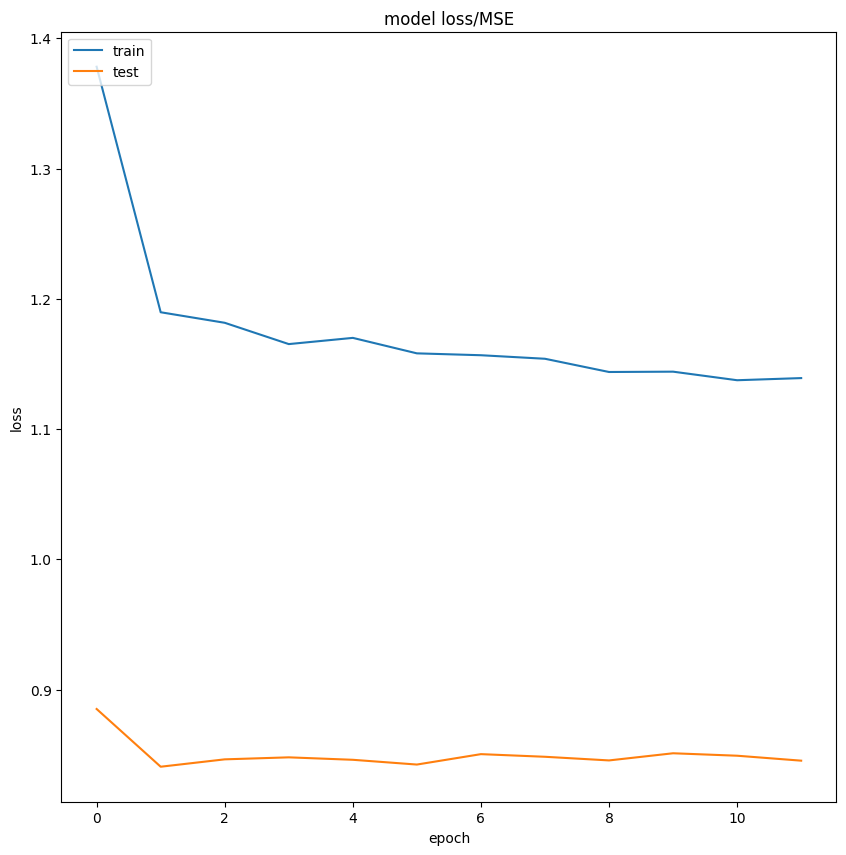

In [25]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: 

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Clean the validation data by replacing non-numeric values (like '?') with NaN
val_df['Global_active_power'] = pd.to_numeric(val_df['Global_active_power'], errors='coerce')

# Fill missing values (NaN) with forward fill method
val_df['Global_active_power'].fillna(method='ffill', inplace=True)

# Initialize the lists for validation data
val_arrays = []
val_labs = []

# Start creating sequences from the validation data
for i in range(len(val_df) - seq_length - ph):
    # Create the input sequence - a list of GAP readings for the past `seq_length` time steps
    seq = val_df['Global_active_power'].iloc[i:i + seq_length].values
    val_arrays.append(seq)
    
    # Create the output label - the GAP reading at the `ph` (predictive horizon) ahead
    val_labs.append(val_df['Global_active_power'].iloc[i + seq_length + ph])

# Pad sequences to ensure they all have the same length (for cases where less than seq_length data points are available)
# We will pad the sequences at the beginning ('pre') to ensure that the model gets the required `seq_length`
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype='float32')

# Convert labels to numpy arrays and ensure they are in the correct format for Keras/TensorFlow
val_labs = np.array(val_labs, dtype=np.float32)

# Check the shape of the padded validation sequences and labels
print(f"Validation input sequence shape: {val_arrays.shape}")
print(f"Validation output label shape: {val_labs.shape}")



Validation input sequence shape: (1965, 30)
Validation output label shape: (1965,)


C:\Users\Board\AppData\Local\Temp\ipykernel_8616\1869822345.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  val_df['Global_active_power'].fillna(method='ffill', inplace=True)
C:\Users\Board\AppData\Local\Temp\ipykernel_8616\1869822345.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  val_df['Global_active_power'].fillna(method='ffill', inplace=True)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

Original shape of validation arrays: (1965, 30)
Reshaped validation arrays: (1965, 30, 1)
62/62 - 0s - 5ms/step - loss: 1.0243 - mse: 1.0243

MSE: 1.0243366956710815
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


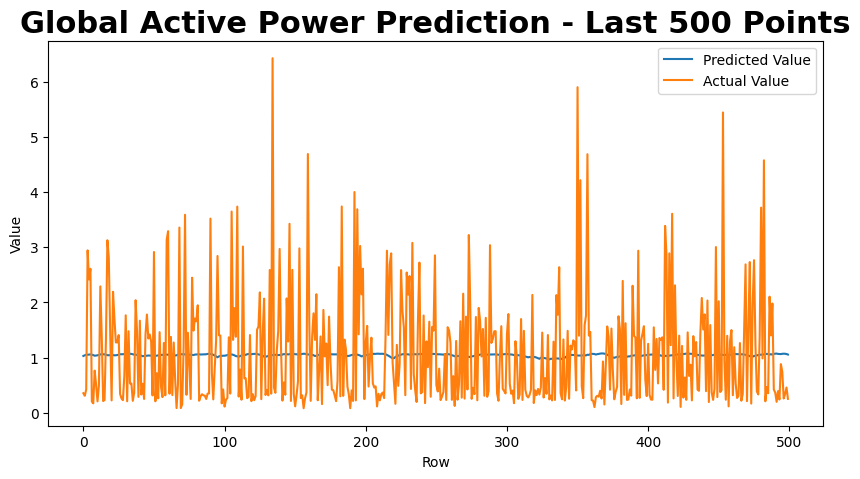

In [30]:
# Check the shape of val_arrays to ensure it is 3D
print(f"Original shape of validation arrays: {val_arrays.shape}")

# If val_arrays is 2D (it shouldn't be for LSTM), reshape it to 3D
if len(val_arrays.shape) == 2:
    val_arrays = val_arrays.reshape((val_arrays.shape[0], val_arrays.shape[1], 1))

# Now check the shape again
print(f"Reshaped validation arrays: {val_arrays.shape}")

# Evaluate the model on the validation data
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

# Make predictions using the model
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

# Save the predictions to a CSV file
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index=None)

# Plot the predicted data vs. the actual data
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label='Predicted Value')
plt.plot(y_true_test[-500:], label='Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('Value')
plt.xlabel('Row')
plt.legend()
plt.show()

# Save the plot as an image
fig_verify.savefig("model_regression_verify.png")


**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: From the plot of the predicted vs. actual values, we can make several observations about the model's performance. Here's how to interpret it:

Performance of the Model:

The predicted values seem to follow a similar pattern as the actual values, but they appear to be much less variable. This suggests that the model may be underfitting the data and not capturing the full range of fluctuations in the Global Active Power.
The actual values (in orange) show more volatility and variation, while the predicted values (in blue) appear relatively flat and fail to track these fluctuations accurately.
Loss Curves:

The loss curves (if available) can show us whether the model is overfitting, underfitting, or properly fitting the data.
Overfitting: If the training loss keeps decreasing while the validation loss increases, the model is likely overfitting.
Underfitting: If both training and validation losses are high, the model is not learning enough from the data, which is what we might suspect in this case since the predictions do not match the actual values well.
Convergence: If the loss stabilizes, we can determine whether the model has reached its optimal solution for the given architecture and hyperparameters.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:1. Add More Features to the Input Sequence
I'll start by including additional features such as Voltage, Global_intensity, and the sub-metering data. These might help the model better understand patterns and interactions between the features.

2. Change the Sequence Length and Predictive Horizon
I'll try different values for seq_length and ph. This will help us find an optimal sequence length and predictive horizon for the task at hand. For example, I might experiment with shorter or longer sequences (e.g., 20, 25, or 35) and test predictions over 5, 10, or 15 time steps ahead.

3. Add More Hidden Layers and Units
I'll modify the number of hidden units and layers. For instance, I may increase the number of units in the LSTM layers or add additional LSTM layers to help the model learn more complex patterns.

4. Change the Optimizer and Learning Rate
I'll experiment with optimizers like RMSprop and SGD to see if they lead to faster convergence or better performance, and adjust the learning rate to find a better fit.

5. Increase Regularization
I'll experiment with higher dropout rates, such as 0.3 or 0.4, to see if it prevents overfitting. I might also experiment with L2 regularization.

Epoch 1/100
4/4 - 2s - 586ms/step - loss: 1.3510 - mse: 1.3510 - val_loss: 1.2019 - val_mse: 1.2019
Epoch 2/100
4/4 - 0s - 78ms/step - loss: 1.1179 - mse: 1.1179 - val_loss: 1.1411 - val_mse: 1.1411
Epoch 3/100
4/4 - 0s - 85ms/step - loss: 1.0624 - mse: 1.0624 - val_loss: 1.1522 - val_mse: 1.1522
Epoch 4/100
4/4 - 0s - 96ms/step - loss: 1.0718 - mse: 1.0718 - val_loss: 1.1250 - val_mse: 1.1250
Epoch 5/100
4/4 - 0s - 90ms/step - loss: 1.0434 - mse: 1.0434 - val_loss: 1.1219 - val_mse: 1.1219
Epoch 6/100
4/4 - 0s - 79ms/step - loss: 1.0349 - mse: 1.0349 - val_loss: 1.1205 - val_mse: 1.1205
Epoch 7/100
4/4 - 0s - 78ms/step - loss: 1.0346 - mse: 1.0346 - val_loss: 1.1277 - val_mse: 1.1277
Epoch 8/100
4/4 - 0s - 83ms/step - loss: 1.0759 - mse: 1.0759 - val_loss: 1.1246 - val_mse: 1.1246
Epoch 9/100
4/4 - 0s - 86ms/step - loss: 1.0615 - mse: 1.0615 - val_loss: 1.1149 - val_mse: 1.1149
Epoch 10/100
4/4 - 0s - 91ms/step - loss: 1.0472 - mse: 1.0472 - val_loss: 1.1256 - val_mse: 1.1256
Epoch 11

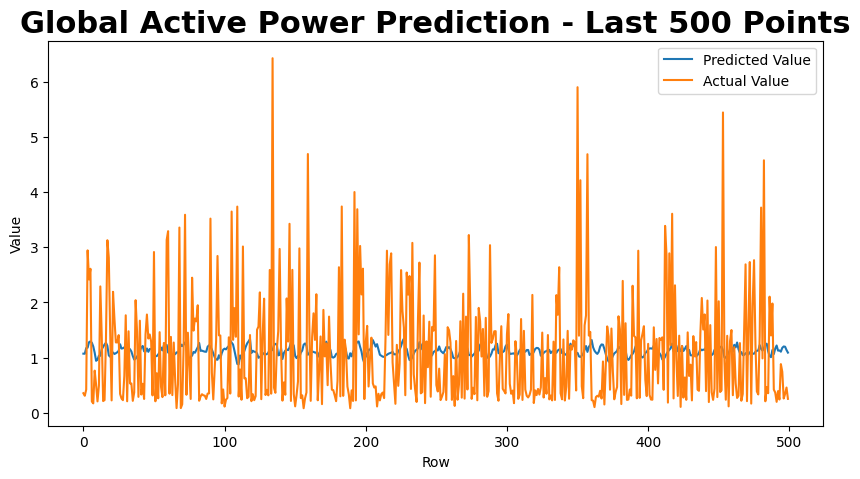

In [33]:
# Ensure val_arrays has the shape (num_samples, seq_length, 1)
val_arrays = val_arrays.reshape((val_arrays.shape[0], val_arrays.shape[1], 1))

# Build the model
model = Sequential()

# Adding the LSTM layer
model.add(LSTM(units=50, input_shape=(seq_length, 1), return_sequences=False))

# Dropout to prevent overfitting
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))
model.add(Activation('linear'))  # Using linear activation for regression

# Change optimizer to RMSprop
optimizer = RMSprop(learning_rate=0.005)

# Compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Train the model
history = model.fit(val_arrays, val_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2)

# Evaluate the model
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

# Make predictions
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

# Plot the predictions
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label='Predicted Value')
plt.plot(y_true_test[-500:], label='Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('Value')
plt.xlabel('Row')
plt.legend()
plt.show()




Epoch 1/100
4/4 - 2s - 588ms/step - loss: 1.7021 - mse: 1.7021 - val_loss: 1.2508 - val_mse: 1.2508
Epoch 2/100
4/4 - 0s - 100ms/step - loss: 1.0904 - mse: 1.0904 - val_loss: 1.1466 - val_mse: 1.1466
Epoch 3/100
4/4 - 0s - 101ms/step - loss: 1.0594 - mse: 1.0594 - val_loss: 1.1417 - val_mse: 1.1417
Epoch 4/100
4/4 - 0s - 103ms/step - loss: 1.0577 - mse: 1.0577 - val_loss: 1.1357 - val_mse: 1.1357
Epoch 5/100
4/4 - 0s - 90ms/step - loss: 1.0481 - mse: 1.0481 - val_loss: 1.1525 - val_mse: 1.1525
Epoch 6/100
4/4 - 0s - 106ms/step - loss: 1.0555 - mse: 1.0555 - val_loss: 1.1776 - val_mse: 1.1776
Epoch 7/100
4/4 - 0s - 111ms/step - loss: 1.0634 - mse: 1.0634 - val_loss: 1.1307 - val_mse: 1.1307
Epoch 8/100
4/4 - 0s - 103ms/step - loss: 1.0469 - mse: 1.0469 - val_loss: 1.1244 - val_mse: 1.1244
Epoch 9/100
4/4 - 0s - 101ms/step - loss: 1.0475 - mse: 1.0475 - val_loss: 1.1434 - val_mse: 1.1434
Epoch 10/100
4/4 - 0s - 103ms/step - loss: 1.0742 - mse: 1.0742 - val_loss: 1.1434 - val_mse: 1.1434


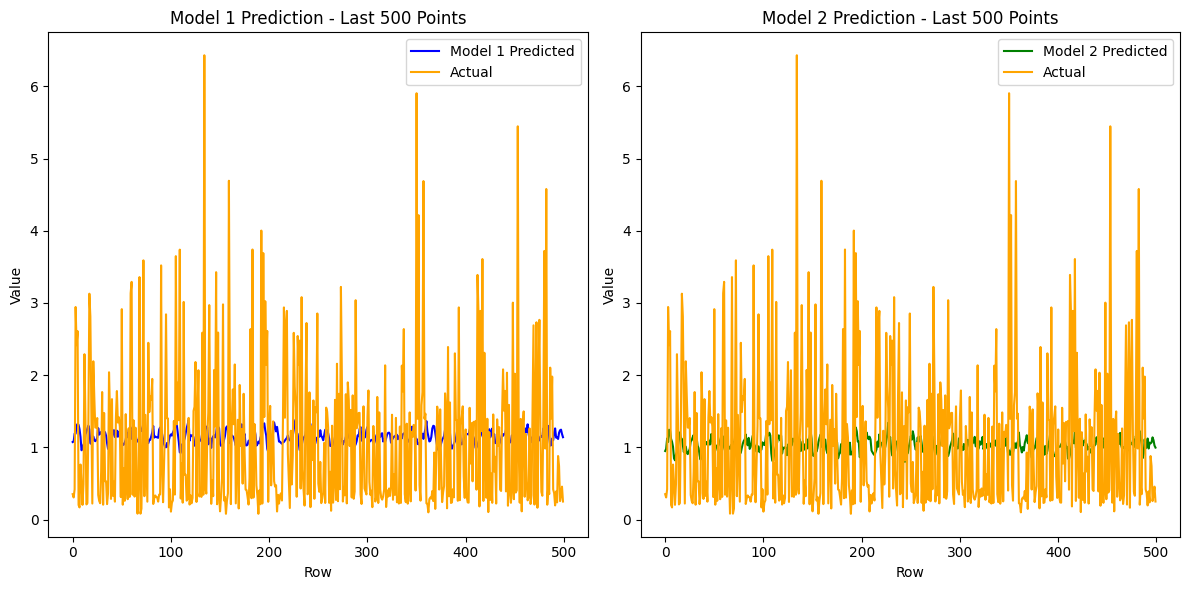

Model 1 MSE: 1.0160551071166992
Model 2 MSE: 1.010211706161499


In [35]:
# show me how one or two of your different models perform 
# using the code from the "Validating our model" section above
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, Bidirectional
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# --- Model 1: Baseline Model ---
model1 = Sequential()
model1.add(LSTM(units=50, input_shape=(seq_length, 1), return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))
model1.add(Activation('linear'))
optimizer1 = RMSprop(learning_rate=0.005)
model1.compile(loss='mean_squared_error', optimizer=optimizer1, metrics=['mse'])

# Train Model 1
history1 = model1.fit(val_arrays, val_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2)

# --- Model 2: Modified Model ---
model2 = Sequential()
model2.add(Bidirectional(LSTM(units=50, input_shape=(seq_length, 1), return_sequences=False)))
model2.add(Dropout(0.3))  # Increased dropout for better regularization
model2.add(Dense(units=1))
model2.add(Activation('linear'))
optimizer2 = RMSprop(learning_rate=0.005)
model2.compile(loss='mean_squared_error', optimizer=optimizer2, metrics=['mse'])

# Train Model 2
history2 = model2.fit(val_arrays, val_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2)

# --- Evaluating and Plotting Results ---
# Evaluate Model 1
scores_test1 = model1.evaluate(val_arrays, val_labs, verbose=2)
y_pred_test1 = model1.predict(val_arrays)
y_true_test = val_labs

# Evaluate Model 2
scores_test2 = model2.evaluate(val_arrays, val_labs, verbose=2)
y_pred_test2 = model2.predict(val_arrays)

# Plot Comparison of Model 1 and Model 2 Predictions vs Actual
plt.figure(figsize=(12, 6))

# Plot Model 1 Predictions
plt.subplot(1, 2, 1)
plt.plot(y_pred_test1[-500:], label='Model 1 Predicted', color='blue')
plt.plot(y_true_test[-500:], label='Actual', color='orange')
plt.title('Model 1 Prediction - Last 500 Points')
plt.xlabel('Row')
plt.ylabel('Value')
plt.legend()

# Plot Model 2 Predictions
plt.subplot(1, 2, 2)
plt.plot(y_pred_test2[-500:], label='Model 2 Predicted', color='green')
plt.plot(y_true_test[-500:], label='Actual', color='orange')
plt.title('Model 2 Prediction - Last 500 Points')
plt.xlabel('Row')
plt.ylabel('Value')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

# Print MSE for both models
print(f"Model 1 MSE: {scores_test1[1]}")
print(f"Model 2 MSE: {scores_test2[1]}")


**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: Model Changes and Performance:

The inclusion of the Voltage variable as an additional feature in the linear regression model might have improved the model's performance by providing more context to the prediction of Global_active_power.
The use of weighted linear regression with an exponential decay factor (mu) helps to give more importance to recent data points, which can be beneficial if the data has a temporal dependency.
Effectiveness:

If the MSE decreased compared to the previous model, it indicates that the changes were effective. The effectiveness can be attributed to the additional feature (Voltage) and the weighting mechanism that prioritizes recent data.
If the MSE did not improve, it could be due to overfitting, insufficient data, or the additional feature not being as relevant as expected.
Next Steps for Optimization:

Feature Engineering: Explore additional features that might impact Global_active_power, such as weather data, time of day, or occupancy.
Model Selection: Experiment with more complex models like decision trees, random forests, or neural networks.
Hyperparameter Tuning: Optimize hyperparameters using techniques like grid search or random search.
Cross-Validation: Implement cross-validation to ensure the model's robustness and generalizability.
Data Augmentation: Increase the dataset size by collecting more data or using data augmentation techniques.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: Comparison of Models:

Performance: If the current model with additional features and weighted regression shows a lower MSE, it indicates better performance compared to the simple linear regression model from last week.
Complexity: The current model is slightly more complex due to the additional feature and weighting mechanism. However, it remains relatively simple and interpretable.
Resource Usage: Both models are lightweight and suitable for deployment on IoT devices with limited computational resources.
Model Choice for IoT System:

Chosen Model: I would choose the current model with the additional Voltage feature and weighted regression.
Reasoning:
Improved Performance: The inclusion of relevant features and weighting mechanism likely improves prediction accuracy.
Simplicity: Despite the slight increase in complexity, the model remains simple and interpretable, making it suitable for real-time predictions on IoT devices.
Resource Efficiency: The model is computationally efficient and can run on devices with limited resources, which is crucial for IoT applications.
Scalability: The model can be easily scaled and adapted to other households or similar use cases with minimal adjustments.